In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
le = preprocessing.LabelEncoder()
from sklearn.model_selection import train_test_split
import pickle
import os


data=pd.read_csv('../../../Sherry-K/data/new_data_old.csv')

In [8]:
print(data.dtypes)
data.head()


Unnamed: 0                    int64
encounter_id                  int64
patient_nbr                   int64
race                         object
gender                       object
age                          object
admission_type_id             int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital              int64
payer_code                   object
medical_specialty            object
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
number_diagnoses              int64
max_glu_serum                object
A1Cresult                    object
metformin                    object
repaglinide                  object
nateglinide                  object
chlorpropamide               object
glimepiride                  object
acetohexamide                object
glipizide                   

,Unnamed: 0,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,change,diabetesMed,readmitin30days,diabetic,f_diag,s_diag,t_diag,self_pay,medicaid/medicare,coverByInsurance
0,0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,...,No,No,0,1.0,"endocrine, nutritional and metabolic diseases,...",No Diagnosis,No Diagnosis,0,0,0
1,1,1968528,720936,Caucasian,Female,[70-80),6,25,1,10,...,Ch,Yes,0,0.0,diseases of the circulatory system,diseases of the circulatory system,"endocrine, nutritional and metabolic diseases,...",0,0,0
2,2,2223336,558360,AfricanAmerican,Female,[60-70),6,25,1,9,...,No,No,0,0.0,injury and poisoning,infectious and parasitic diseases,diseases of the musculoskeletal system and con...,0,0,0
3,3,2298006,2519748,Caucasian,Male,[60-70),6,25,1,4,...,Ch,Yes,0,0.0,diseases of the respiratory system,"endocrine, nutritional and metabolic diseases,...",diseases of the circulatory system,0,0,0
4,4,2356308,608841,AfricanAmerican,Female,[50-60),6,25,1,1,...,No,Yes,0,1.0,"endocrine, nutritional and metabolic diseases,...",diseases of the circulatory system,"endocrine, nutritional and metabolic diseases,...",0,0,0


In [9]:
X = data.copy()

In [ ]:
X = X.drop(['Unnamed: 0','patient_nbr','encounter_id', 'payer_code', 'medical_specialty','diabetic' ], axis = 1)


In [48]:
dead_ids = [11, 13, 14, 19,20,21]
X = X[~X['discharge_disposition_id'].isin(dead_ids)]

In [49]:
X.dtypes

race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone               object
acarbose                    object
miglitol            

In [12]:
X['readmitin30days'] = le.fit_transform(X['readmitin30days'])

In [35]:
for x in list(X.columns):
    print(X.groupby('readmitin30days')[x].value_counts())

readmitin30days  race           
0                Caucasian          67507
                 AfricanAmerican    17055
                 Other               3446
                 Hispanic            1825
                 Asian                576
1                Caucasian           8592
                 AfricanAmerican     2155
                 Other                333
                 Hispanic             212
                 Asian                 65
Name: race, dtype: int64
readmitin30days  gender         
0                Female             48556
                 Male               41850
                 Unknown/Invalid        3
1                Female              6152
                 Male                5205
Name: gender, dtype: int64
readmitin30days  age     
0                [70-80)     22999
                 [60-70)     19981
                 [50-60)     15588
                 [80-90)     15119
                 [40-50)      8658
                 [30-40)      3351
                

readmitin30days  nateglinide
0                No             89786
                 Steady           590
                 Up                23
                 Down              10
1                No             11277
                 Steady            78
                 Down               1
                 Up                 1
Name: nateglinide, dtype: int64
readmitin30days  chlorpropamide
0                No                90328
                 Steady               74
                 Up                    6
                 Down                  1
1                No                11352
                 Steady                5
Name: chlorpropamide, dtype: int64
readmitin30days  glimepiride
0                No             85748
                 Steady          4202
                 Up               290
                 Down             169
1                No             10827
                 Steady           468
                 Up                37
                 Down      

In [90]:
## changing id features from numerical to categorical 

X['admission_type_id'] = pd.Categorical(X.admission_type_id)
X['discharge_disposition_id'] = pd.Categorical(X.discharge_disposition_id)
X['admission_source_id'] = pd.Categorical(X.admission_source_id)


## changing object features to categorical
cat_cols = list(X.select_dtypes(include=[object]).columns)

for col in cat_cols:
    X[col] = pd.Categorical(X[col])


In [92]:
## label encoding all categorical variables to feed into rf

col_to_encode = X[list(X.select_dtypes(include=['category']).columns)]


for col in col_to_encode:
    X[col] = le.fit_transform(X[col])


In [93]:
## creating target variable and dropping from data set

Y = X['readmitin30days']
X = X.drop('readmitin30days', axis = 1)

In [94]:
X.dtypes

race                        int64
gender                      int64
age                         int64
admission_type_id           int64
discharge_disposition_id    int64
admission_source_id         int64
time_in_hospital            int64
num_lab_procedures          int64
num_procedures              int64
num_medications             int64
number_outpatient           int64
number_emergency            int64
number_inpatient            int64
number_diagnoses            int64
max_glu_serum               int64
A1Cresult                   int64
metformin                   int64
repaglinide                 int64
nateglinide                 int64
chlorpropamide              int64
glimepiride                 int64
acetohexamide               int64
glipizide                   int64
glyburide                   int64
tolbutamide                 int64
pioglitazone                int64
rosiglitazone               int64
acarbose                    int64
miglitol                    int64
troglitazone  

In [95]:
Y.value_counts()

0    90409
1    11357
Name: readmitin30days, dtype: int64

### Running RandomSearch to narrow down the params

In [ ]:
## setting initial search params

model=ensemble.RandomForestClassifier(random_state=0)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_para = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rand_search_rf = RandomizedSearchCV(model, random_para, cv=4)

rand_search_rf.fit(data, readmitted)


### Gridsearch to find best params for rf model

In [ ]:


##predict test data
#randomForest.predict(test)
model=ensemble.RandomForestClassifier(oob_score = True, random_state=0, class_weight = {0:1,1:8})

###Grid Search

n_estimators = [1100]
max_features = ['sqrt']
max_depth = [55]
min_samples_split = [12, 14]
min_samples_leaf = [2]
bootstrap = [True]
grid_para = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

grid_search_forest = GridSearchCV(model, grid_para, cv=4,scoring = "f1")
grid_search_forest.fit(data, readmitted)

bestparam= grid_search_forest.best_params_
bestscore= grid_search_forest.best_score_





In [102]:
# Fit the model
model = ensemble.RandomForestClassifier(oob_score=True, random_state = 0,**bestparam, class_weight = {0:1, 1:8})
#model.set_params(bestparam)
model.fit(X, Y)
model.score(X, Y)

0.9926104985948155

In [80]:
model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 8},
            criterion='gini', max_depth=55, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=14, min_weight_fraction_leaf=0.0,
            n_estimators=1100, n_jobs=None, oob_score=True, random_state=0,
            verbose=0, warm_start=False)>

In [81]:
print(bestparam)
print(bestscore)
#model.score(data, readmitted)


{'bootstrap': True, 'max_depth': 55, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 14, 'n_estimators': 1100}
0.06145109806598271


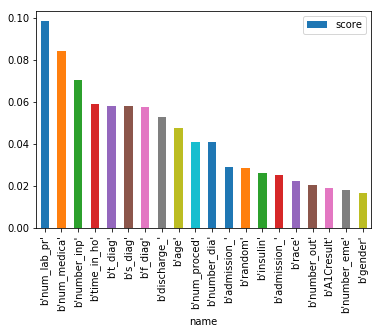

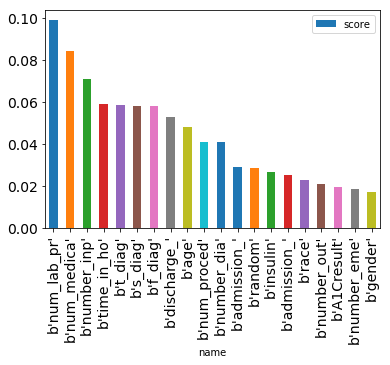

In [104]:

##feature importance
feature_importance = list(zip(X.columns, model.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
fea_i=pd.DataFrame({'name':name,'score':score})
fea_i[:20].plot.bar(x='name', y='score')
fea_i

my_fig = fea_i[:20].plot.bar(x='name', y='score')
my_fig.tick_params(labelsize=14)
#my_fig.figure.savefig('my_fig.png', dpi=300, bbox_inches = 'tight')


In [101]:
## adding random feature column to have baseline to select most important features

X['random'] = np.random.randint(0,3, X.shape[0])
X['random'].value_counts()

1    34044
2    34005
0    33717
Name: random, dtype: int64

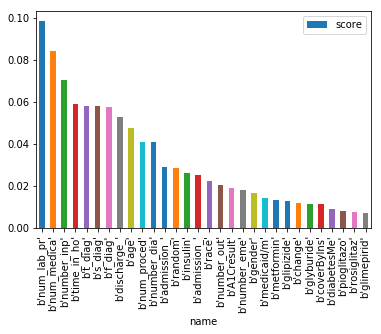

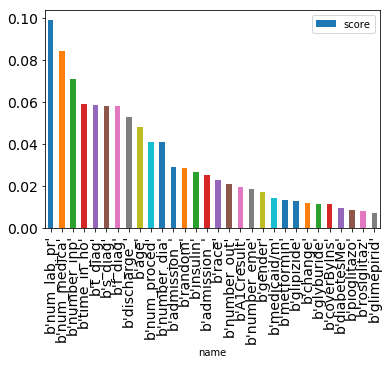

In [105]:

##feature importance
feature_importance = list(zip(X.columns, model.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
fea_i=pd.DataFrame({'name':name,'score':score})
fea_i[:30].plot.bar(x='name', y='score')
fea_i

my_fig = fea_i[:30].plot.bar(x='name', y='score')
my_fig.tick_params(labelsize=14)
my_fig.figure.savefig('my_fig.png', dpi=300, bbox_inches = 'tight')


In [26]:
data = data.drop('random', axis = 1)

In [99]:
y_predict = model.predict(X)
confusion_matrix(Y, y_predict)

array([[90022,   387],
       [  454, 10903]])